# Предсказание оттока клиента телеком-компании

In [1]:
# Использование графической памяти(ставить True не советую)
import rmm
#rmm.reinitialize(pool_allocator=True)

# Работа с данными
import pandas as pd
import cupy as cp
import numpy as np

# Работа с тесктом
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# Просто милота
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
nltk.download('punkt')

/home/egor/miniconda3/envs/lama_venv/lib/python3.8/site-packages/cupy/_environment.py:440: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda11x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
[nltk_data] Downloading package punkt to /home/egor/nltk_data...
[nltk_data]   Package punkt is already up-

True

## Импорт данных

In [2]:
df = pd.read_csv('dataset.csv', encoding='Windows 1251')

In [3]:
df[['residence_address', 'service_delivery_address']].head()

,residence_address,service_delivery_address
0,"Тюмень, ул. Харьковская, д. 59, 52","Тюменская область, р-н.Тюменский, д.Патрушева,..."
1,"Тюмень, ул. 50 лет ВЛКСМ, д. 15, корпус 1, 62","Тюменская область, г.Тюмень, ул.50 лет ВЛКСМ, ..."
2,"Тюмень, ул. Щербакова, д. 142, корпус 1, 3","Тюменская область, г.Тюмень, ул.Революции, д.2..."
3,"Тюмень, ул. Калужская, д. 5","Тюменская область, г.Тюмень, ул.Калужская, д.5"
4,"625000, обл.Тюменская, г.Тюмень, ул.Советская,...","Тюменская область, г.Тюмень, ул.Революции, д.2..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25829 entries, 0 to 25828
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id_client                 25829 non-null  int64 
 1   client_type               25829 non-null  object
 2   internet_dynamic          25829 non-null  int64 
 3   cable_tv                  25829 non-null  int64 
 4   internet_fixed            25829 non-null  int64 
 5   dedicated_channels        25829 non-null  int64 
 6   internet_static           25829 non-null  int64 
 7   other_services            25829 non-null  int64 
 8   payment_period            25829 non-null  int64 
 9   time_in_company           25829 non-null  int64 
 10  residence_address         25829 non-null  object
 11  service_delivery_address  25829 non-null  object
 12  churn_rate                25829 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 2.6+ MB


In [5]:
# Обработка данных фактического места и адреса прописки
def comparison_kv(data, cols):
    j = 0
    new = []
    
    for i in tqdm(data[cols[0]]):
        x = i[-1].replace(" ", "")
        if x in data[cols[1]][j][-1]:
            new.append(1)
            j+=1
        else:
            new.append(0)
            j+=1
            
    return new

def comparison_dress(data, cols):
    
    for col in tqdm(cols):
        data[col] = data.apply(lambda row: word_tokenize(row[col]), axis=1)
    
    #data[cols[1]] = data.apply(lambda row: TreebankWordDetokenizer().detokenize(row[cols[1]]), axis=1)
    arr = comparison_kv(data, cols)

    return arr
        
        

In [6]:
x = comparison_dress(df, ['residence_address', 'service_delivery_address'])

100%|█████████████████████████████████| 25829/25829 [00:00<00:00, 280438.20it/s]


In [7]:
df['comparison_dress'] = x

In [8]:
df[['residence_address', 'service_delivery_address']].head()

,residence_address,service_delivery_address
0,"[Тюмень, ,, ул, ., Харьковская, ,, д, ., 59, ,...","[Тюменская, область, ,, р-н.Тюменский, ,, д.Па..."
1,"[Тюмень, ,, ул, ., 50, лет, ВЛКСМ, ,, д, ., 15...","[Тюменская, область, ,, г.Тюмень, ,, ул.50, ле..."
2,"[Тюмень, ,, ул, ., Щербакова, ,, д, ., 142, ,,...","[Тюменская, область, ,, г.Тюмень, ,, ул.Револю..."
3,"[Тюмень, ,, ул, ., Калужская, ,, д, ., 5]","[Тюменская, область, ,, г.Тюмень, ,, ул.Калужс..."
4,"[625000, ,, обл.Тюменская, ,, г.Тюмень, ,, ул....","[Тюменская, область, ,, г.Тюмень, ,, ул.Револю..."


In [9]:
df = df[['id_client', 'client_type', 'internet_dynamic', 'cable_tv',
       'internet_fixed', 'dedicated_channels', 'internet_static',
       'other_services', 'payment_period', 'time_in_company', 'comparison_dress', 'churn_rate']]

In [10]:
df.head()

,id_client,client_type,internet_dynamic,cable_tv,internet_fixed,dedicated_channels,internet_static,other_services,payment_period,time_in_company,comparison_dress,churn_rate
0,7173342,ФЛ,-1,0,0,0,0,0,833,2,0,0
1,7213588,ФЛ,-1,0,0,0,0,0,482,2,1,0
2,7751264,ФЛ,-1,-1,0,0,0,0,565,2,0,0
3,7084810,ФЛ,-1,0,0,0,0,0,120,3,1,0
4,7764589,ФЛ,-1,0,0,0,0,0,325,2,0,0


## Кодирование данных от 0 до 1

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
min_max = MinMaxScaler()


payment_period_np = df['payment_period'].to_numpy()
df['payment_period'] = min_max.fit_transform(payment_period_np.reshape(-1,1))

In [13]:
df['client_type'].unique()

array(['ФЛ   ', 'ФЛКЦ '], dtype=object)

In [14]:
def categorial(data, col):
    uniq = data[col].unique()
    j = 0
    
    for i in tqdm(uniq):
        data.loc[(data[col] == i), col] = j
        j+=1

In [15]:
categorial(df, 'client_type')

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 719.25it/s]


## Удаление выбросов по метрике payment_period

In [16]:
def box_plot_fig(data):
    
    for i in df.columns:
        fig, axs = plt.subplots()
        sns.boxplot(data[i])
        axs.legend([i])
        plt.show()

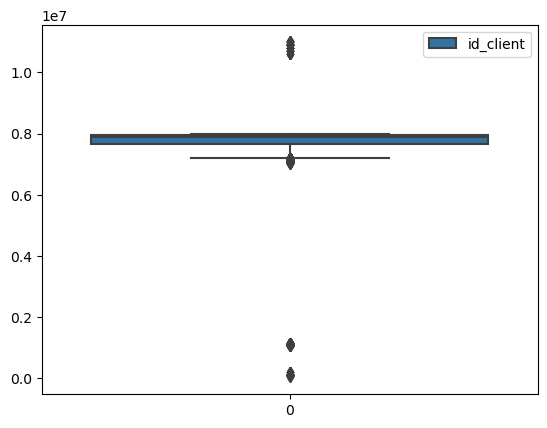

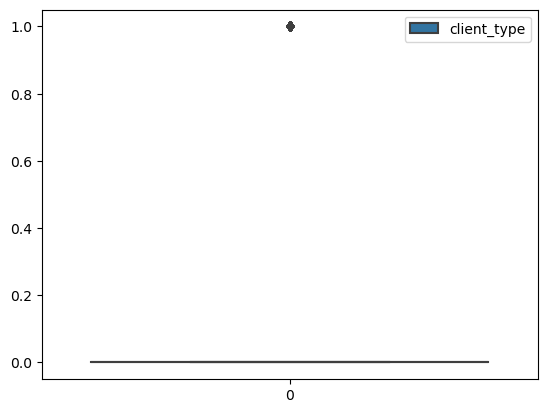

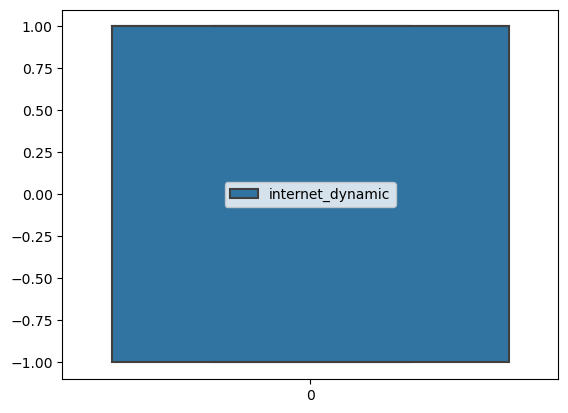

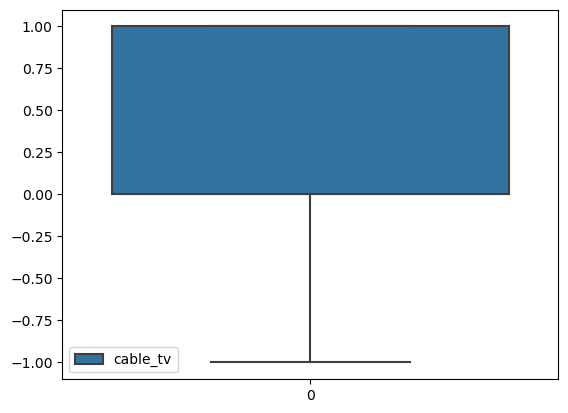

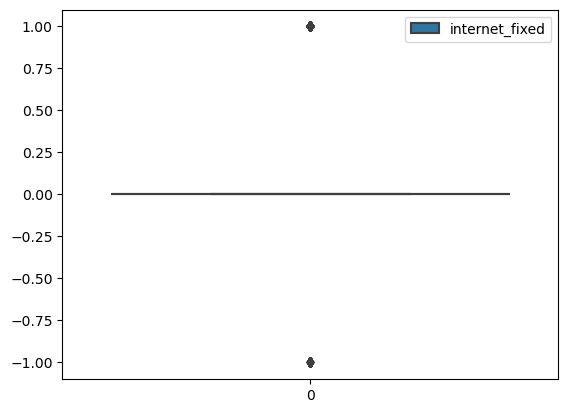

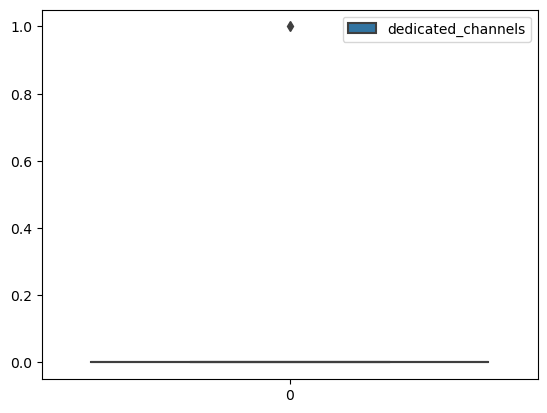

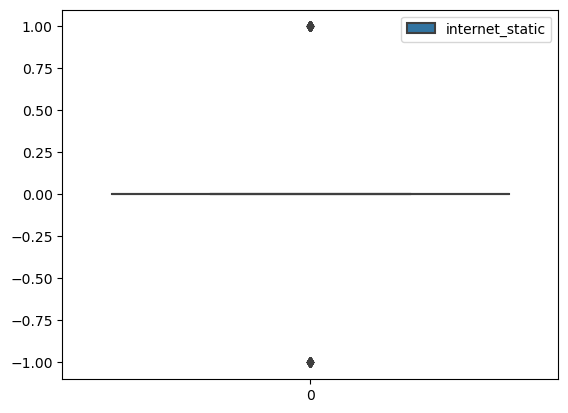

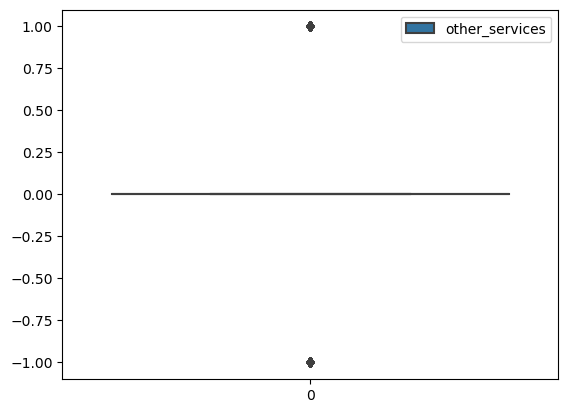

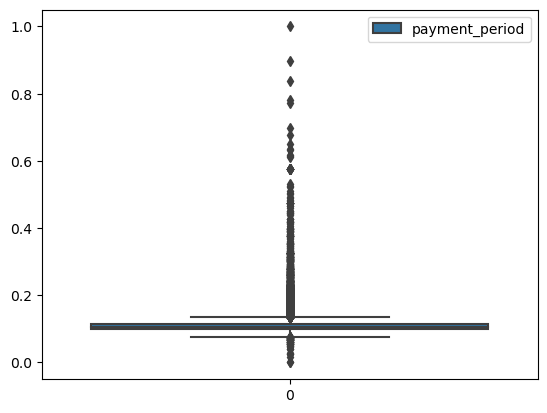

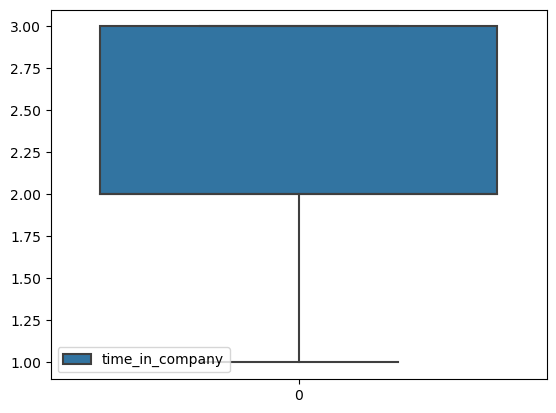

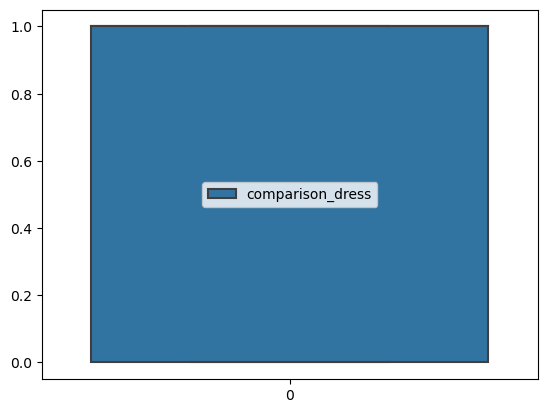

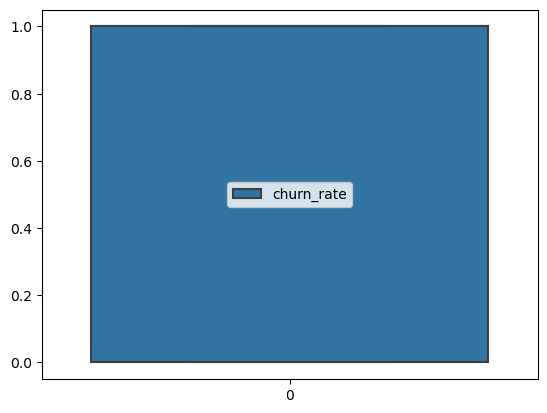

In [17]:
box_plot_fig(df)

In [18]:
x = df.loc[(df['payment_period'] <= 0.125) & (df['payment_period'] >= 0.082)]

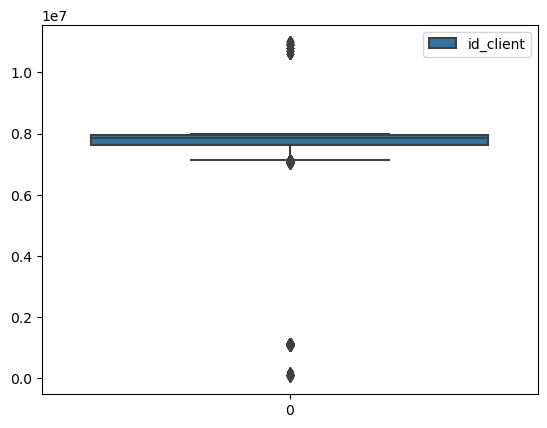

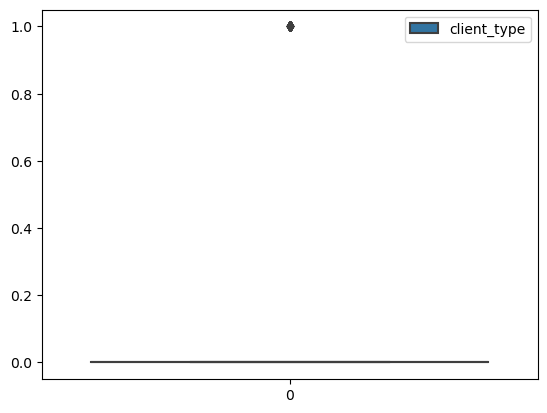

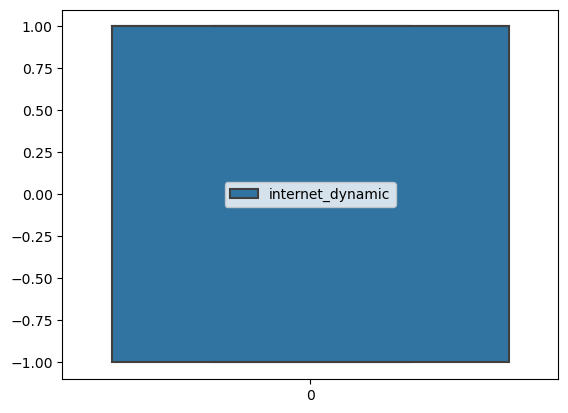

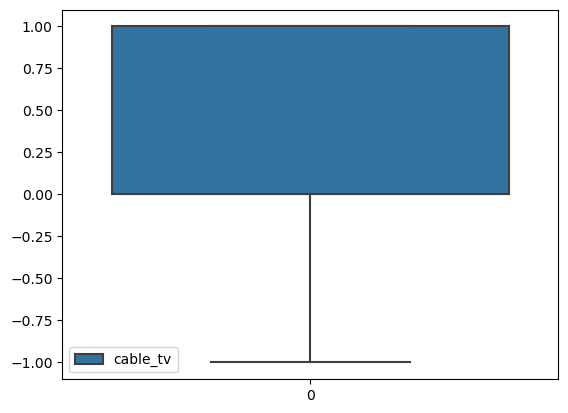

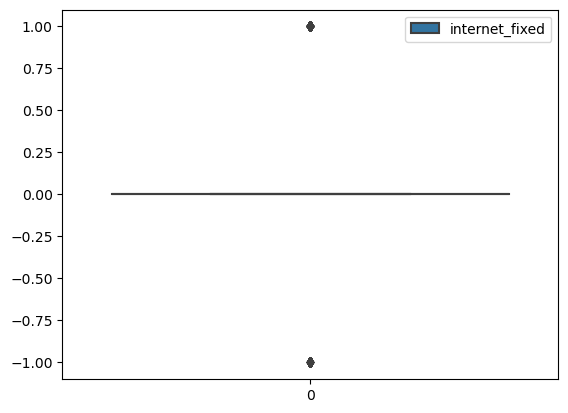

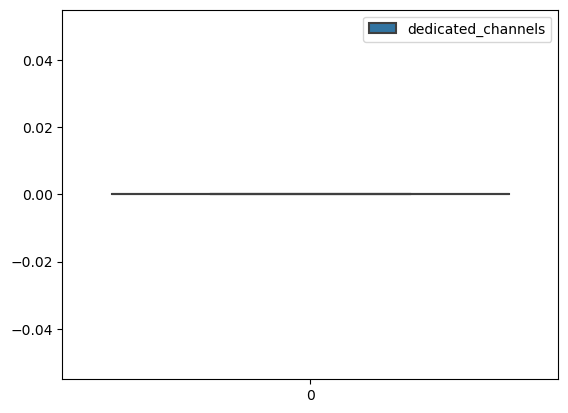

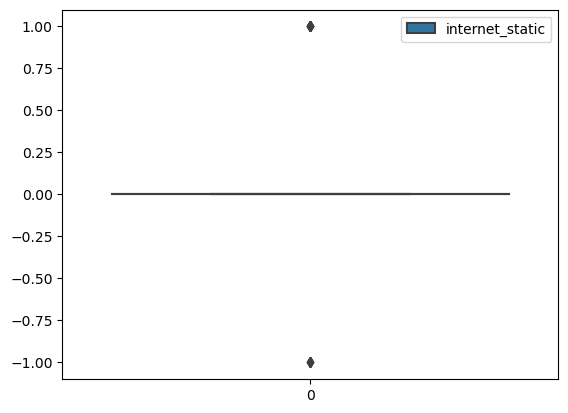

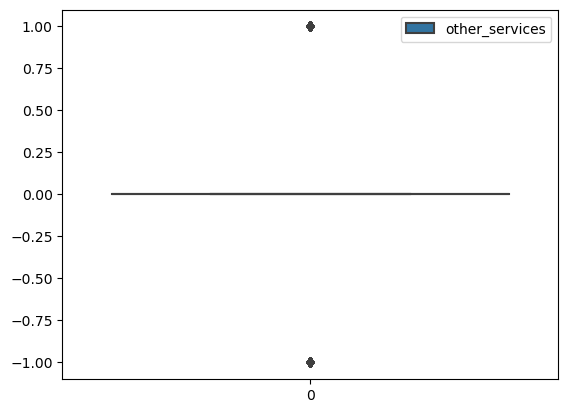

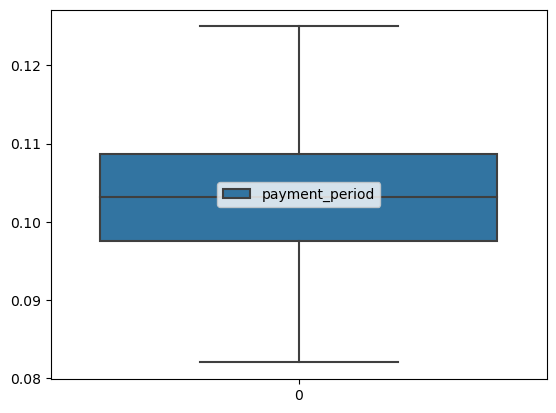

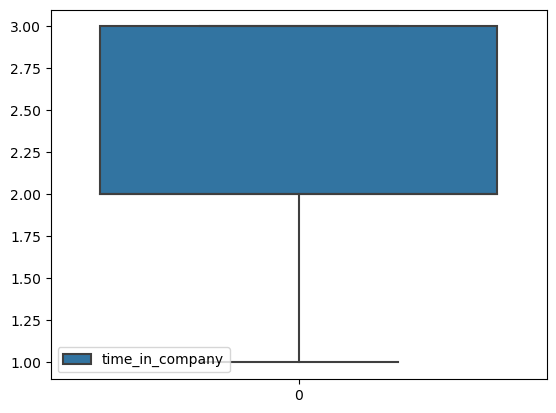

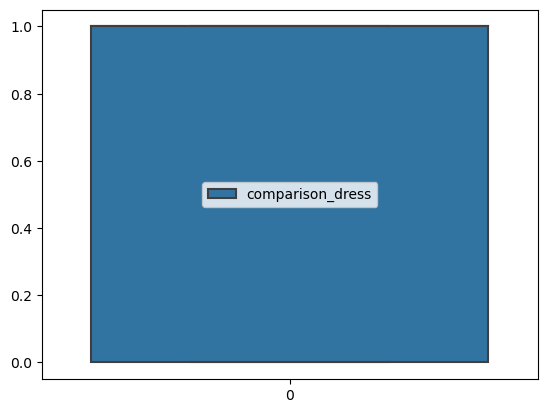

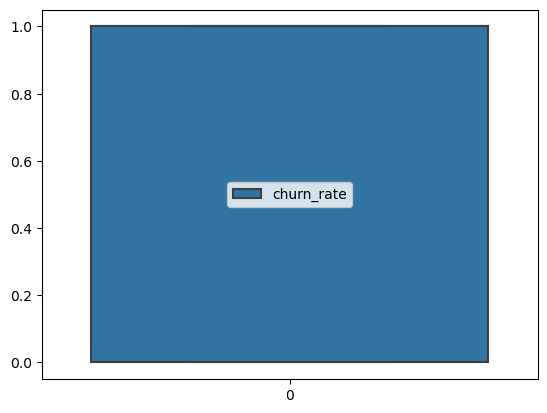

In [19]:
box_plot_fig(x)

In [20]:
df = x

In [21]:
df

,id_client,client_type,internet_dynamic,cable_tv,internet_fixed,dedicated_channels,internet_static,other_services,payment_period,time_in_company,comparison_dress,churn_rate
0,7173342,0,-1,0,0,0,0,0,0.120248,2,0,0
1,7213588,0,-1,0,0,0,0,0,0.102829,2,1,0
2,7751264,0,-1,-1,0,0,0,0,0.106948,2,0,0
3,7084810,0,-1,0,0,0,0,0,0.084864,3,1,0
4,7764589,0,-1,0,0,0,0,0,0.095037,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
25818,7965309,1,1,0,0,0,0,0,0.111166,3,0,1
25819,7965413,1,1,0,0,0,0,0,0.111067,3,0,1
25820,7967567,1,0,0,0,0,1,0,0.116129,3,0,1
25827,7813949,0,1,0,0,0,0,0,0.106551,2,1,1


## График корреляции

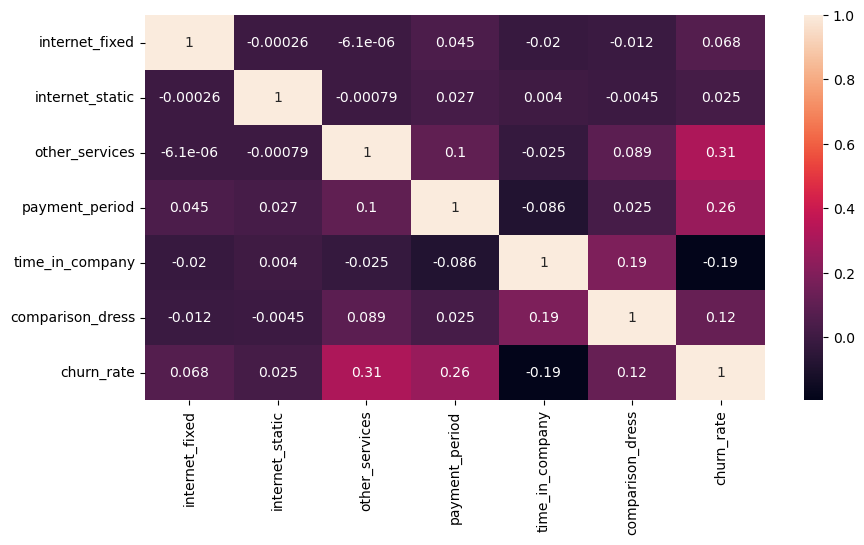

In [22]:
fig, axs = plt.subplots(figsize=(10,5))
sns.heatmap(df.drop(['id_client', 'cable_tv', 'dedicated_channels', 'internet_dynamic'], axis=1).corr(), annot=True)
plt.show()

In [23]:
# Импорт моделей из библиотеки Cuml
from catboost import CatBoostClassifier
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.linear_model import LogisticRegression
from xgboost import XGBClassifier
from cuml.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, f1_score

## Инициализация моделей

In [24]:
cat_boost = CatBoostClassifier(task_type="GPU", devices='0:1', silent=True)
model = cuRF()
lg_clf = LogisticRegression()
xg_clf = XGBClassifier()

## Подбор парамметров для GridSearch

In [25]:
params_rf = {'n_estimators': [200], 
            'min_samples_split': range(2,21,2),
            'min_samples_leaf': range(1,11)
}

params_cat_boost = {}

params_lg = {'C': range(1,21),
            }

params_xg = {}

In [32]:
grid_cat_boost = GridSearchCV(cat_boost, params_cat_boost)
grid_lg = GridSearchCV(lg_clf, params_lg)
grid_xg = GridSearchCV(xg_clf, params_xg)
grid_cuda = GridSearchCV(model, params_rf)

In [33]:
df.client_type = df.client_type.astype('int64')

In [34]:
import cudf
df = cudf.from_pandas(df)

## Разделение данных

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['id_client', 'churn_rate', 'cable_tv', 'dedicated_channels', 'internet_dynamic'], axis=1), df['churn_rate'],
                                                    test_size=0.33, random_state=42)

In [36]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [36]:
def model_fit(models, train, test):
    
    models_app = []
    roc_auc_score_ = []
    score_ = []
    f1_sc = []
    
    
    for model in tqdm(models):
        model.fit(train[0], train[1])
        pred = model.predict(test[0])
        
        score_model = model.score(test[0], test[1])
        roc_auc_model = roc_auc_score(test[1], pred)
        f1_model = f1_score(test[1], pred)
        
        score_.append(score_model)
        roc_auc_score_.append(roc_auc_model)
        f1_sc.append(f1_model)
        
    return models, roc_auc_score_, score_, f1_sc
        

## Обучение моделей

In [37]:
model_arr, roc_auc_arr, score_arr, f1_sc = model_fit([grid_cuda, grid_lg, grid_xg, grid_cat_boost], [X_train, y_train], [X_test, y_test])

100%|████████████████████████████████████████████| 4/4 [08:39<00:00, 129.92s/it]


In [42]:
df_model = pd.DataFrame(data = {
    'model': model_arr,
    'score': score_arr,
    'roc_auc_score': roc_auc_arr,
    'f1_score': f1_sc
})
df_model

,model,score,roc_auc_score,f1_score
0,GridSearchCV(estimator=RandomForestClassifier(...,0.782865,0.652690,0.863234
1,"GridSearchCV(estimator=LogisticRegression(), p...",0.781039,0.649679,0.862243
2,GridSearchCV(estimator=XGBClassifier(base_scor...,0.775702,0.662069,0.855226
3,GridSearchCV(estimator=<catboost.core.CatBoost...,0.783427,0.658717,0.862591


## Обучение нейросети

In [27]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2023-06-21 15:01:36.238443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:01:37.210592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-06-21 15:01:39.236177: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-21 15:01:40.354611: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
[]


In [28]:
def model_nn_fit(model, iter_, train, test, loss, optimizer, metrics, epochs, batch_size, verbose):
    
    roc_auc_score_ = []
    score_ = []
    f1_ = []
    
    train[1] = to_categorical(train[1])
    test_cat = to_categorical(test[1])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    
    for i in tqdm(range(iter_)):
        
        pred_arr = []
        
        model.fit(train[0], train[1], epochs=epochs, batch_size=batch_size, verbose=verbose)
        
        loss, accuracy, auc = model_mnist.evaluate(test[0], test_cat)
        pred = model.predict(test[0])
        score_.append(accuracy)
        
        
        roc_auc_score_.append(auc)
        #f1_.append(f1_score(test[1], pred_arr))
        
    return model, score_, roc_auc_score_, f1_

In [29]:
model_mnist = Sequential()
model_mnist.add(Dense(800, activation='relu', input_dim=7))
#model_mnist.add(Dropout(0.5))
model_mnist.add(Dense(400, activation='relu',))
model_mnist.add(Dense(2, activation='softmax'))

2023-06-21 15:01:40.987976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-21 15:01:40.989337: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [37]:
nn_models, score_nn, roc_auc_nn, f1 = model_nn_fit(model_mnist, iter_=1, train=[X_train, y_train], test=[X_test, y_test], epochs=10, batch_size=5, verbose=1, loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', AUC()])

  0%|                                                     | 0/1 [00:00<?, ?it/s]

Epoch 1/10
2892/2892 [==============================] - 7s 2ms/step - loss: 0.5047 - accuracy: 0.7767 - auc: 0.8186
Epoch 2/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4910 - accuracy: 0.7822 - auc: 0.8294
Epoch 3/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4874 - accuracy: 0.7830 - auc: 0.8319
Epoch 4/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4862 - accuracy: 0.7833 - auc: 0.8340
Epoch 5/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4848 - accuracy: 0.7841 - auc: 0.8364
Epoch 6/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4841 - accuracy: 0.7832 - auc: 0.8363
Epoch 7/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4830 - accuracy: 0.7834 - auc: 0.8385
Epoch 8/10
2892/2892 [==============================] - 6s 2ms/step - loss: 0.4823 - accuracy: 0.7830 - auc: 0.8396
Epoch 9/10
2892/2892 [==============================] - 6s 2ms/step - lo

100%|█████████████████████████████████████████████| 1/1 [01:03<00:00, 63.85s/it]


In [38]:
nn_models.predict(X_test)

223/223 [==============================] - 0s 965us/step


array([[0.2617892 , 0.73821074],
       [0.2274898 , 0.77251023],
       [0.25363338, 0.7463666 ],
       ...,
       [0.9479302 , 0.05206968],
       [0.40541887, 0.5945812 ],
       [0.24001707, 0.75998294]], dtype=float32)

In [39]:
df_nn = pd.DataFrame(data = {
    'model': nn_models,
    'score': score_nn,
    'auc': roc_auc_nn
})

In [40]:
df_nn

,model,score,auc
0,<keras.engine.sequential.Sequential object at ...,0.778933,0.847736
